In [ ]:
# ============================================================
# Appendix A.0. System Environment Specification
# ------------------------------------------------------------
# Purpose:
# Capture and report full software–hardware configuration used
# in computational experiments, ensuring reproducibility.
# ============================================================

import platform
import pandas as pd

print("=== SOFTWARE ENVIRONMENT ===")
print(f"Python version: {platform.python_version()}")
print(f"Pandas version: {pd.__version__}")
print(f"Operating System: {platform.system()} {platform.release()} ({platform.version()})")
print(f"Processor: {platform.processor()}")

# CuPy diagnostics (used in GPU simulations)
try:
    import cupy as cp
    print("\nCuPy version:", cp.__version__)
    print("CuPy memory pool (bytes used):",
          cp.get_default_memory_pool().used_bytes())
except Exception:
    print("\nCuPy not installed.")

# PyTorch diagnostics (primary GPU backend)
try:
    import torch
    print("\nPyTorch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("CUDA device name:", torch.cuda.get_device_name(0))
        print("CUDA device count:", torch.cuda.device_count())
except Exception:
    print("\nPyTorch not detected.")


=== SOFTWARE ENVIRONMENT ===
Python version: 3.9.25
Pandas version: 2.3.3
Operating System: Windows 10 (10.0.26200)
Processor: Intel64 Family 6 Model 154 Stepping 3, GenuineIntel

CuPy version: 13.6.0
CuPy memory pool (bytes used): 0

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
CUDA device count: 1


In [ ]:
# ============================================================
# Appendix A.0.1 — GPU Validation and Performance Benchmark
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Research Context:
#   Mentor–Mentee Optimization (Euclidean Distance Modeling,
#   Vectorized Degree Representations, and Linear Algebra Acceleration)
# Institution: University of Texas at San Antonio
#
# Purpose:
#   This appendix provides an empirical validation of GPU acceleration
#   for the computational components used in this research. Two core
#   workloads are benchmarked on both CPU and GPU:
#
#     (1) Large-scale matrix multiplication (PyTorch), representative of
#         the vector–matrix operations underlying the Euclidean distance
#         matrix in the mentor–mentee optimization model.
#
#     (2) High-dimensional simulation (CuPy), reflecting the iterative
#         GPU-based procedures used during model diagnostics,
#         sensitivity checks, and distance-matrix verification.
#
#   The results confirm that the NVIDIA RTX 3070 Ti Laptop GPU provides
#   an ~18× acceleration relative to CPU execution, ensuring that all
#   computational experiments in this study were conducted under a
#   validated and reproducible hardware–software environment.
# ============================================================

import time
import torch
import cupy as cp
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# PyTorch GPU vs CPU — Matrix Multiplication Benchmark
# ------------------------------------------------------------
print("\n=== PyTorch Benchmark (Matrix Multiply) ===")

N = 4000  # 4000×4000 matrices

# CPU computation
a_cpu = torch.rand(N, N)
b_cpu = torch.rand(N, N)

start = time.time()
_ = torch.mm(a_cpu, b_cpu)
cpu_time_torch = time.time() - start

# GPU computation
device_gpu = torch.device("cuda")
a_gpu = a_cpu.to(device_gpu)
b_gpu = b_cpu.to(device_gpu)
torch.cuda.synchronize()

start = time.time()
_ = torch.mm(a_gpu, b_gpu)
torch.cuda.synchronize()
gpu_time_torch = time.time() - start

print(f"CPU time: {cpu_time_torch:.4f} s")
print(f"GPU time: {gpu_time_torch:.4f} s")
print(f"Speed-up: {cpu_time_torch / gpu_time_torch:.2f}×")


# ------------------------------------------------------------
# CuPy GPU vs CPU — Monte Carlo Simulation Benchmark
# ------------------------------------------------------------
print("\n=== CuPy Benchmark (Monte Carlo Simulation) ===")

N = 8_000_000  # 8 million draws

# ---- CPU version (NumPy) ----
start = time.time()
x_cpu = np.random.randn(N)
sum_cpu = x_cpu.sum()
cpu_time_sim = time.time() - start

# ---- GPU version (CuPy) ----
cp.cuda.Stream.null.synchronize()
start = time.time()
x_gpu = cp.random.randn(N)
sum_gpu = cp.sum(x_gpu)
cp.cuda.Stream.null.synchronize()
gpu_time_sim = time.time() - start

print(f"CPU time: {cpu_time_sim:.4f} s")
print(f"GPU time: {gpu_time_sim:.4f} s")
print(f"Speed-up: {cpu_time_sim / gpu_time_sim:.2f}×")


# ------------------------------------------------------------
# Benchmark Summary Table (for the Appendix)
# ------------------------------------------------------------
results = pd.DataFrame({
    "Benchmark": [
        "PyTorch Matrix Multiply",
        "CuPy Monte Carlo Simulation"
    ],
    "CPU Time (s)": [
        cpu_time_torch,
        cpu_time_sim
    ],
    "GPU Time (s)": [
        gpu_time_torch,
        gpu_time_sim
    ],
    "Speed-up (×)": [
        cpu_time_torch / gpu_time_torch,
        cpu_time_sim / gpu_time_sim
    ]
})

print("\nBenchmark Summary:")
print(results.to_string(index=False))



=== PyTorch Benchmark (Matrix Multiply) ===
CPU time: 0.3995 s
GPU time: 0.0214 s
Speed-up: 18.66×

=== CuPy Benchmark (Monte Carlo Simulation) ===
CPU time: 0.1321 s
GPU time: 0.0071 s
Speed-up: 18.65×

Benchmark Summary:
                  Benchmark  CPU Time (s)  GPU Time (s)  Speed-up (×)
    PyTorch Matrix Multiply      0.399549      0.021418     18.655134
CuPy Monte Carlo Simulation      0.132129      0.007087     18.645191


In [ ]:
import os, sys
print(os.getcwd())
print(sys.executable)

%pwd
# on laptop
# 'c:\\Users\\efrai\\OneDrive - University of Texas at San Antonio\\Documents\\Research\\program'

/home/efrain/workspace/projects/mentor-matching-optimization/notebooks
/home/efrain/workspace/projects/mentor-matching-optimization/.venv/bin/python


'/home/efrain/workspace/projects/mentor-matching-optimization/notebooks'

In [ ]:
# ============================================================
# Appendix A.1. Data Preparation and Downcasting Protocol
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
# This appendix documents the complete data-preparation pipeline applied to
# the initial Excel dataset ("degree_reference.xlsx", sheet "degree_courses").
# The workflow ensures lexical consistency, enforces strict binary typing for
# the degree–course inclusion matrix Xᵢⱼ, and exports a GPU-compatible Parquet
# file for subsequent Euclidean-distance computations and optimization modeling.
# ============================================================

from __future__ import annotations
from pathlib import Path
import pandas as pd

# ----------------------------
# Paths (anchored to repo root)
# ----------------------------
PROJECT_ROOT = Path.cwd().parent  # notebooks/ → project root
IN_PATH = PROJECT_ROOT / "data/raw/degree_reference.xlsx"
OUT_PATH = PROJECT_ROOT / "data/features/degree_course_matrix.parquet"
SHEET = "degree_courses"

def main() -> None:
    if not IN_PATH.exists():
        raise FileNotFoundError(f"Missing input file: {IN_PATH.resolve()}")

    # ------------------------------------------------------------
    # 1. Load raw dataset
    # ------------------------------------------------------------
    degree_raw = pd.read_excel(IN_PATH, sheet_name=SHEET)
    print(
        f"Loaded raw dataset with "
        f"{degree_raw.shape[0]} rows x {degree_raw.shape[1]} columns."
    )

    # ------------------------------------------------------------
    # 2. Clean column names (preserve exact degree titles)
    # ------------------------------------------------------------
    degree_work = degree_raw.copy()
    degree_work.columns = [
        str(c).strip().replace("\xa0", " ")
        for c in degree_work.columns
    ]

    # ------------------------------------------------------------
    # 3. Strip whitespace inside string cells
    # ------------------------------------------------------------
    degree_work = degree_work.apply(
        lambda col: col.map(lambda x: x.strip() if isinstance(x, str) else x)
    )
    # ------------------------------------------------------------
    # 4. Identify degree columns
    # ------------------------------------------------------------
    degree_cols = degree_work.columns[1:]
    print(f"Detected {len(degree_cols)} degree program columns.")

    # ------------------------------------------------------------
    # 5. Coerce degree columns to numeric (0/1)
    # ------------------------------------------------------------
    for col in degree_cols:
        degree_work[col] = (
            pd.to_numeric(degree_work[col], errors="coerce")
            .fillna(0)
            .astype("int8")   # <—— optimal for vector operations
        )

        # Safety check: must be binary
        unique_vals = set(degree_work[col].unique())
        if not unique_vals.issubset({0, 1}):
           raise ValueError(f"Non-binary values detected in column: {col}")

    # ------------------------------------------------------------
    # 6. Remove blanks / duplicates
    # ------------------------------------------------------------
    degree_clean = (
        degree_work
        .dropna(how="all")
        .drop_duplicates()
        .reset_index(drop=True)
    )

    # ------------------------------------------------------------
    # 7. Downcast memory & verify structure
    # ------------------------------------------------------------
    print("\n=== Final DataFrame Summary (Numeric 0/1) ===")
    degree_clean.info(memory_usage="deep")

    # ------------------------------------------------------------
    # 8. Export to Parquet for GPU workflows
    # ------------------------------------------------------------
    OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    degree_clean.to_parquet(OUT_PATH, index=False)
    
    print(f"\nSaved degree-course matrix to:\n  {OUT_PATH.resolve()}")
    print("\nPreview:")
    print(degree_clean.iloc[15:21, :5])

if __name__ == "__main__":
    main()

Loaded raw dataset with 342 rows x 18 columns.
Detected 17 degree program columns.

=== Final DataFrame Summary (Numeric 0/1) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 18 columns):
 #   Column                                                                      Non-Null Count  Dtype 
---  ------                                                                      --------------  ----- 
 0   Course Code                                                                 342 non-null    object
 1   B.B.A. Degree in Accounting                                                 342 non-null    int8  
 2   B.A. Degree in Economics                                                    342 non-null    int8  
 3   B.B.A. Degree in Economics                                                  342 non-null    int8  
 4   B.B.A. Degree in Finance                                                    342 non-null    int8  
 5   B.B.A. Degree in Real Estate Fin

In [6]:
# ============================================================
# Appendix A.2. Data Import and Structural Verification
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
# Imports the cleaned dataset ("degree_course_matrix.parquet")
# produced in Appendix A.1 and performs minimal structural checks
# to confirm reproducibility and readiness for vector construction.
#
# Verifications:
#   (1) File loads successfully with preserved dtypes.
#   (2) All degree columns retain Integer type.
#   (3) No missing (<NA>) values exist in the matrix Xᵢⱼ.
# ============================================================

from pathlib import Path
import pandas as pd

# ------------------------------------------------------------
# 1. Load preprocessed dataset
# ------------------------------------------------------------
PROJECT_ROOT = Path.cwd().parent  # notebooks/ → project root
IN_PATH = PROJECT_ROOT / "data/features/degree_course_matrix.parquet"

degree_course_matrix = pd.read_parquet(IN_PATH)

print("Loaded degree-course matrix:")
print(degree_course_matrix.shape)
degree_course_matrix.info()

# ------------------------------------------------------------
# 2. Structural verification (minimal reproducibility checks)
# ------------------------------------------------------------
# Assertions ensure that the dataset structure is preserved
# precisely as generated in Appendix A.1.
# ------------------------------------------------------------

# Expect exactly one identifier column + 17 degree columns
assert degree_course_matrix.shape[1] == 18, "Unexpected column count in imported dataset."

# All degree columns (excluding 'Course Code') must be Integer
degree_cols = degree_course_matrix.columns[1:]
assert all(
    degree_course_matrix[col].dtype == "int8" for col in degree_cols
), "Non-Integer columns detected in degree matrix."
# No missing values permitted in Xᵢⱼ
assert not degree_course_matrix.isna().any().any(), "Missing values detected in dataset."
print("Structural verification complete — dataset integrity confirmed.")

# ------------------------------------------------------------
# 3. Ready for analytical operations
# ------------------------------------------------------------
# The verified DataFrame (degree_course_matrix) now represents the binary
# inclusion matrix Xᵢⱼ and will be used for constructing vectors
# and computing pairwise Euclidean distances in Appendix A.3.
# ------------------------------------------------------------


Loaded degree-course matrix:
(342, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 18 columns):
 #   Column                                                                      Non-Null Count  Dtype 
---  ------                                                                      --------------  ----- 
 0   Course Code                                                                 342 non-null    object
 1   B.B.A. Degree in Accounting                                                 342 non-null    int8  
 2   B.A. Degree in Economics                                                    342 non-null    int8  
 3   B.B.A. Degree in Economics                                                  342 non-null    int8  
 4   B.B.A. Degree in Finance                                                    342 non-null    int8  
 5   B.B.A. Degree in Real Estate Finance and Development                        342 non-null    int8  
 6   B.B.A. Degree in Cy

In [3]:
# ============================================================
# Appendix A.2. Construction of the Degree Program Dictionary
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
# Defines a standardized dictionary that maps each degree program’s
# full institutional title to:
#   (1) a short, human-readable label (Short_Name),
#   (2) a mathematical index variable (Xᵢ) for optimization modeling,
#   (3) a machine-safe variable identifier (Variable_Name).
#
# This dictionary formalizes the reference between symbolic model
# indices and degree names, ensuring transparency and reproducibility
# in subsequent vector-based analyses.
# Each Variable_Name serves as the canonical vector key used to index
# columns and rows in distance and optimization matrices (Appendices A.5–A.7).
# ============================================================

import pandas as pd
import re

# ------------------------------------------------------------
# 1. Load verified dataset from Appendix A.1
# ------------------------------------------------------------
input_file = "ACOB_Degree_Courses_Clean.feather"
degrees_df = pd.read_feather(input_file).convert_dtypes()
assert not degrees_df.isna().any().any(), "Integrity check failed: Missing values present."
print(f"Verified import: {degrees_df.shape[0]} courses × {degrees_df.shape[1]-1} degree programs")

# Extract degree program columns (all columns except the first)
degree_cols = degrees_df.columns[1:]
n_degrees = len(degree_cols)
print(f"Detected {n_degrees} degree programs for dictionary construction.")

# ------------------------------------------------------------
# 2. Initialize the degree dictionary (1-based indexing)
# ------------------------------------------------------------
# Index i corresponds to each degree i ∈ {1, 2, …, n}.
# This indexing aligns with mathematical notation Xᵢ used in
# subsequent vector and optimization frameworks.
# ------------------------------------------------------------
degree_dict = pd.DataFrame(
    {"Full_Name": degree_cols},
    index=pd.RangeIndex(start=1, stop=n_degrees + 1, step=1)
)

# ------------------------------------------------------------
# 3. Generate standardized short names
# ------------------------------------------------------------
# Controlled regular-expression substitutions remove prefixes such as
# “B.B.A. Degree in”, “B.A. Degree in”, and “B.S. Degree in”, yielding
# concise labels suitable for reference tables and model documentation.
# ------------------------------------------------------------
degree_dict["Short_Name"] = (
    degree_dict["Full_Name"]
    .str.replace(r"(?i)b\.?b\.?a\.?\s*degree\s*in\s*", "", regex=True)
    .str.replace(r"(?i)b\.?a\.?\s*degree\s*in\s*", "BA ", regex=True)
    .str.replace(r"(?i)b\.?s\.?\s*degree\s*in\s*", "BS ", regex=True)
    .str.replace(r"(?i)\(hrm\)\s*track", "HRM Track", regex=True)
    .str.replace(r"\s*-\s*", " ", regex=True)   # normalize stray hyphens
    .str.strip()
)

# Disambiguate similar or overlapping titles
degree_dict["Short_Name"] = degree_dict["Short_Name"].replace({
    "Economics": "BBA Economics",
    "BA Economics": "BA Economics",
    "Management with Human Resources Management HRM Track":
        "Management with Human Resources Management Track"
})

# ------------------------------------------------------------
# 4. Assign mathematical index variable (Xᵢ)
# ------------------------------------------------------------
# The column “Xᵢ” provides a formal identifier for each degree i,
# used consistently in mathematical notation and optimization models.
# ------------------------------------------------------------
degree_dict["Xᵢ"] = degree_dict.index

# ------------------------------------------------------------
# 5. Map standardized machine-safe variable names
# ------------------------------------------------------------
# Each Short_Name is mapped to a concise lowercase identifier following
# a consistent pattern suitable for code, databases, and APIs.
# ------------------------------------------------------------
custom_code_map = {
    "Accounting": "accounting",
    "BA Economics": "economics_ba",
    "BBA Economics": "economics_bba",
    "Finance": "finance",
    "Real Estate Finance and Development": "real_estate_fin_dev",
    "Cyber Security": "cyber_sec",
    "Information Systems and Technology": "is_tech",
    "BS Applied Cyber Analytics": "cyber_analytics",
    "Human Resources Management": "hrm",
    "Management": "management",
    "Management with Human Resources Management Track": "management_hrm_track",
    "Actuarial Science": "actuarial_sci",
    "Business Analytics": "business_analytics",
    "Operations and Supply Chain Management": "operations_scm",
    "BS Statistics and Data Science": "statistics_ds",
    "Marketing": "marketing",
    "Marketing with a Sport Event and Tourism Management Track": "marketing_set"
}

degree_dict["Variable_Name"] = degree_dict["Short_Name"].map(custom_code_map)

# Validation: identify any unmapped entries to prevent silent NaN
unmapped = degree_dict[degree_dict["Variable_Name"].isna()]
if not unmapped.empty:
    print("\nWarning: unmapped Short_Name entries detected:")
    print(unmapped[["Full_Name", "Short_Name"]].to_string(index=True))
else:
    print("All Short_Name entries successfully mapped to Variable_Name identifiers.")

# ------------------------------------------------------------
# 6. Construct Canonical Program Identifier (BBA_Degree_in_…)
# ------------------------------------------------------------
def make_canonical(name):
    if pd.isna(name):
        return pd.NA
    s = (name.replace(".", "")
             .replace(",", "")
             .replace("&", "and")
             .replace("-", " ")
             .strip()
             .replace(" ", "_"))
    s = re.sub(r"_+", "_", s)  # collapse multiple underscores
    return s

degree_dict["Canonical_Name"] = degree_dict["Full_Name"].apply(make_canonical)

# ------------------------------------------------------------
# 6b. Reorder columns for publication and modeling clarity
# ------------------------------------------------------------
column_order = ["Xᵢ", "Variable_Name", "Full_Name", "Short_Name", "Canonical_Name"]
degree_dict = degree_dict[column_order]

# ------------------------------------------------------------
# 7. Export finalized dictionary (workflow + publication)
# ------------------------------------------------------------
# Feather → reproducible analytical workflows
# Excel   → publication / appendix table
# ------------------------------------------------------------
degree_dict.to_feather("ACOB_Degree_Dictionary.feather")
degree_dict.to_excel("ACOB_Degree_Dictionary.xlsx", index=False, float_format="%.0f")

print("\nDegree dictionary successfully exported in Feather and Excel formats.")
print("Saved files:")
print("  - ACOB_Degree_Dictionary.feather  (for analysis)")
print("  - ACOB_Degree_Dictionary.xlsx      (for publication)")

# ------------------------------------------------------------
# Utility: format_tight() for compact console display
# ------------------------------------------------------------
import textwrap

def format_tight(df, max_width=50):
    """Left-justify and truncate long text columns for console output."""
    df_formatted = df.copy()
    for col in df_formatted.columns:
        df_formatted[col] = df_formatted[col].apply(
            lambda x: textwrap.shorten(str(x), width=max_width, placeholder="…")
        )
    return df_formatted

# ------------------------------------------------------------
# Formatted console preview (left-justified + truncate)
# ------------------------------------------------------------
print("\nPreview of degree dictionary:")
preview_df = format_tight(degree_dict.head(20), max_width=50)
print(preview_df.to_string(index=False, justify="right"))


Verified import: 342 courses × 17 degree programs
Detected 17 degree programs for dictionary construction.
All Short_Name entries successfully mapped to Variable_Name identifiers.

Degree dictionary successfully exported in Feather and Excel formats.
Saved files:
  - ACOB_Degree_Dictionary.feather  (for analysis)
  - ACOB_Degree_Dictionary.xlsx      (for publication)

Preview of degree dictionary:
Xᵢ        Variable_Name                                          Full_Name                                       Short_Name                                    Canonical_Name
 1           accounting                        B.B.A. Degree in Accounting                                       Accounting                          BBA_Degree_in_Accounting
 2         economics_ba                           B.A. Degree in Economics                                     BA Economics                            BA_Degree_in_Economics
 3        economics_bba                         B.B.A. Degree in Economics   

In [4]:
# ============================================================
# Appendix A.3 — Construction and Inspection of Inclusion Matrix X
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
#   Constructs the binary inclusion matrix X = [xᵢⱼ], where
#   each degree i ∈ {1,…,n} is represented as a binary vector
#   across all course indices j ∈ {1,…,m}.
#
#   The matrix is transposed (degrees × courses) to facilitate
#   row-oriented inspection and later vector-based distance
#   computations (see Appendix A.5).
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# 1. Load the structured dataset from Appendix A.1
# ------------------------------------------------------------
degrees_df = pd.read_feather("ACOB_Degree_Courses_Clean.feather").convert_dtypes()
print(f"Loaded structured dataset → shape = {degrees_df.shape}")

# ------------------------------------------------------------
# 2. Extract the inclusion matrix X = [xᵢⱼ]
# ------------------------------------------------------------
# The first column ('Course Code') contains identifiers j.
# All subsequent columns correspond to degree programs i.
# ------------------------------------------------------------
X = degrees_df.iloc[:, 1:]
degree_labels = X.columns
print(f"Original inclusion matrix shape: {X.shape} → (m courses × n degrees)")

# ------------------------------------------------------------
# 3. Transpose to obtain degree-wise orientation (Xᵀ)
# ------------------------------------------------------------
# Each row in Xᵀ now represents one degree i as a binary vector.
# This form is used in Euclidean and IDF-weighted distance modeling.
# ------------------------------------------------------------
X_T = X.T
print(f"Transposed matrix shape: {X_T.shape} → (n degrees × m courses)")

# ------------------------------------------------------------
# 4. Preview
# ------------------------------------------------------------
# For transparency, we display the first three degree vectors
# over the first ten courses. The display index begins at 1
# (matching the symbolic index i used in Xᵢⱼ formulations).
# ------------------------------------------------------------
print("\nSample of transposed inclusion matrix (first 3 degrees × 10 courses):")

display_df = X_T.iloc[:3, :10].astype(int).copy()
display_df.index = range(1, len(display_df) + 1)
display_df.index.name = "Degree Index (i)"
print(display_df.to_string(index=True))

# ------------------------------------------------------------
# 5. Illustrative example — one degree vector
# ------------------------------------------------------------
# The following prints the binary vector for the first degree
# (“B.B.A. Degree in Accounting”) over its first 25 course entries.
# This provides an intuitive view of how curricular composition
# is represented numerically within the model.
# ------------------------------------------------------------
sample_degree = degree_labels[0]
sample_vector = X_T.loc[sample_degree].astype(int).to_numpy()[:25]
print(f"\nBinary vector for '{sample_degree}' (first 25 entries):")
print(sample_vector)

# ------------------------------------------------------------
# 6. Export matrix for downstream modeling
# ------------------------------------------------------------
# The matrix Xᵀ is serialized in Apache Feather format, ensuring
# schema preservation and zero-copy compatibility with GPU-based
# analytical workflows (Appendices A.5–A.7).
# ------------------------------------------------------------
X_T.to_feather("ACOB_Inclusion_Matrix_T.feather")
print("\nFeather export complete → 'ACOB_Inclusion_Matrix_T.feather'")


Loaded structured dataset → shape = (342, 18)
Original inclusion matrix shape: (342, 17) → (m courses × n degrees)
Transposed matrix shape: (17, 342) → (n degrees × m courses)

Sample of transposed inclusion matrix (first 3 degrees × 10 courses):
                  0  1  2  3  4  5  6  7  8  9
Degree Index (i)                              
1                 1  1  1  0  1  1  1  1  1  1
2                 1  1  1  0  1  1  1  1  1  1
3                 1  1  1  0  1  1  1  1  1  1

Binary vector for 'B.B.A. Degree in Accounting' (first 25 entries):
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0]

Feather export complete → 'ACOB_Inclusion_Matrix_T.feather'


Matrix X constructed: 17 degrees × 342 courses

Export complete: Euclidean and IDF matrices saved (Feather + Excel).


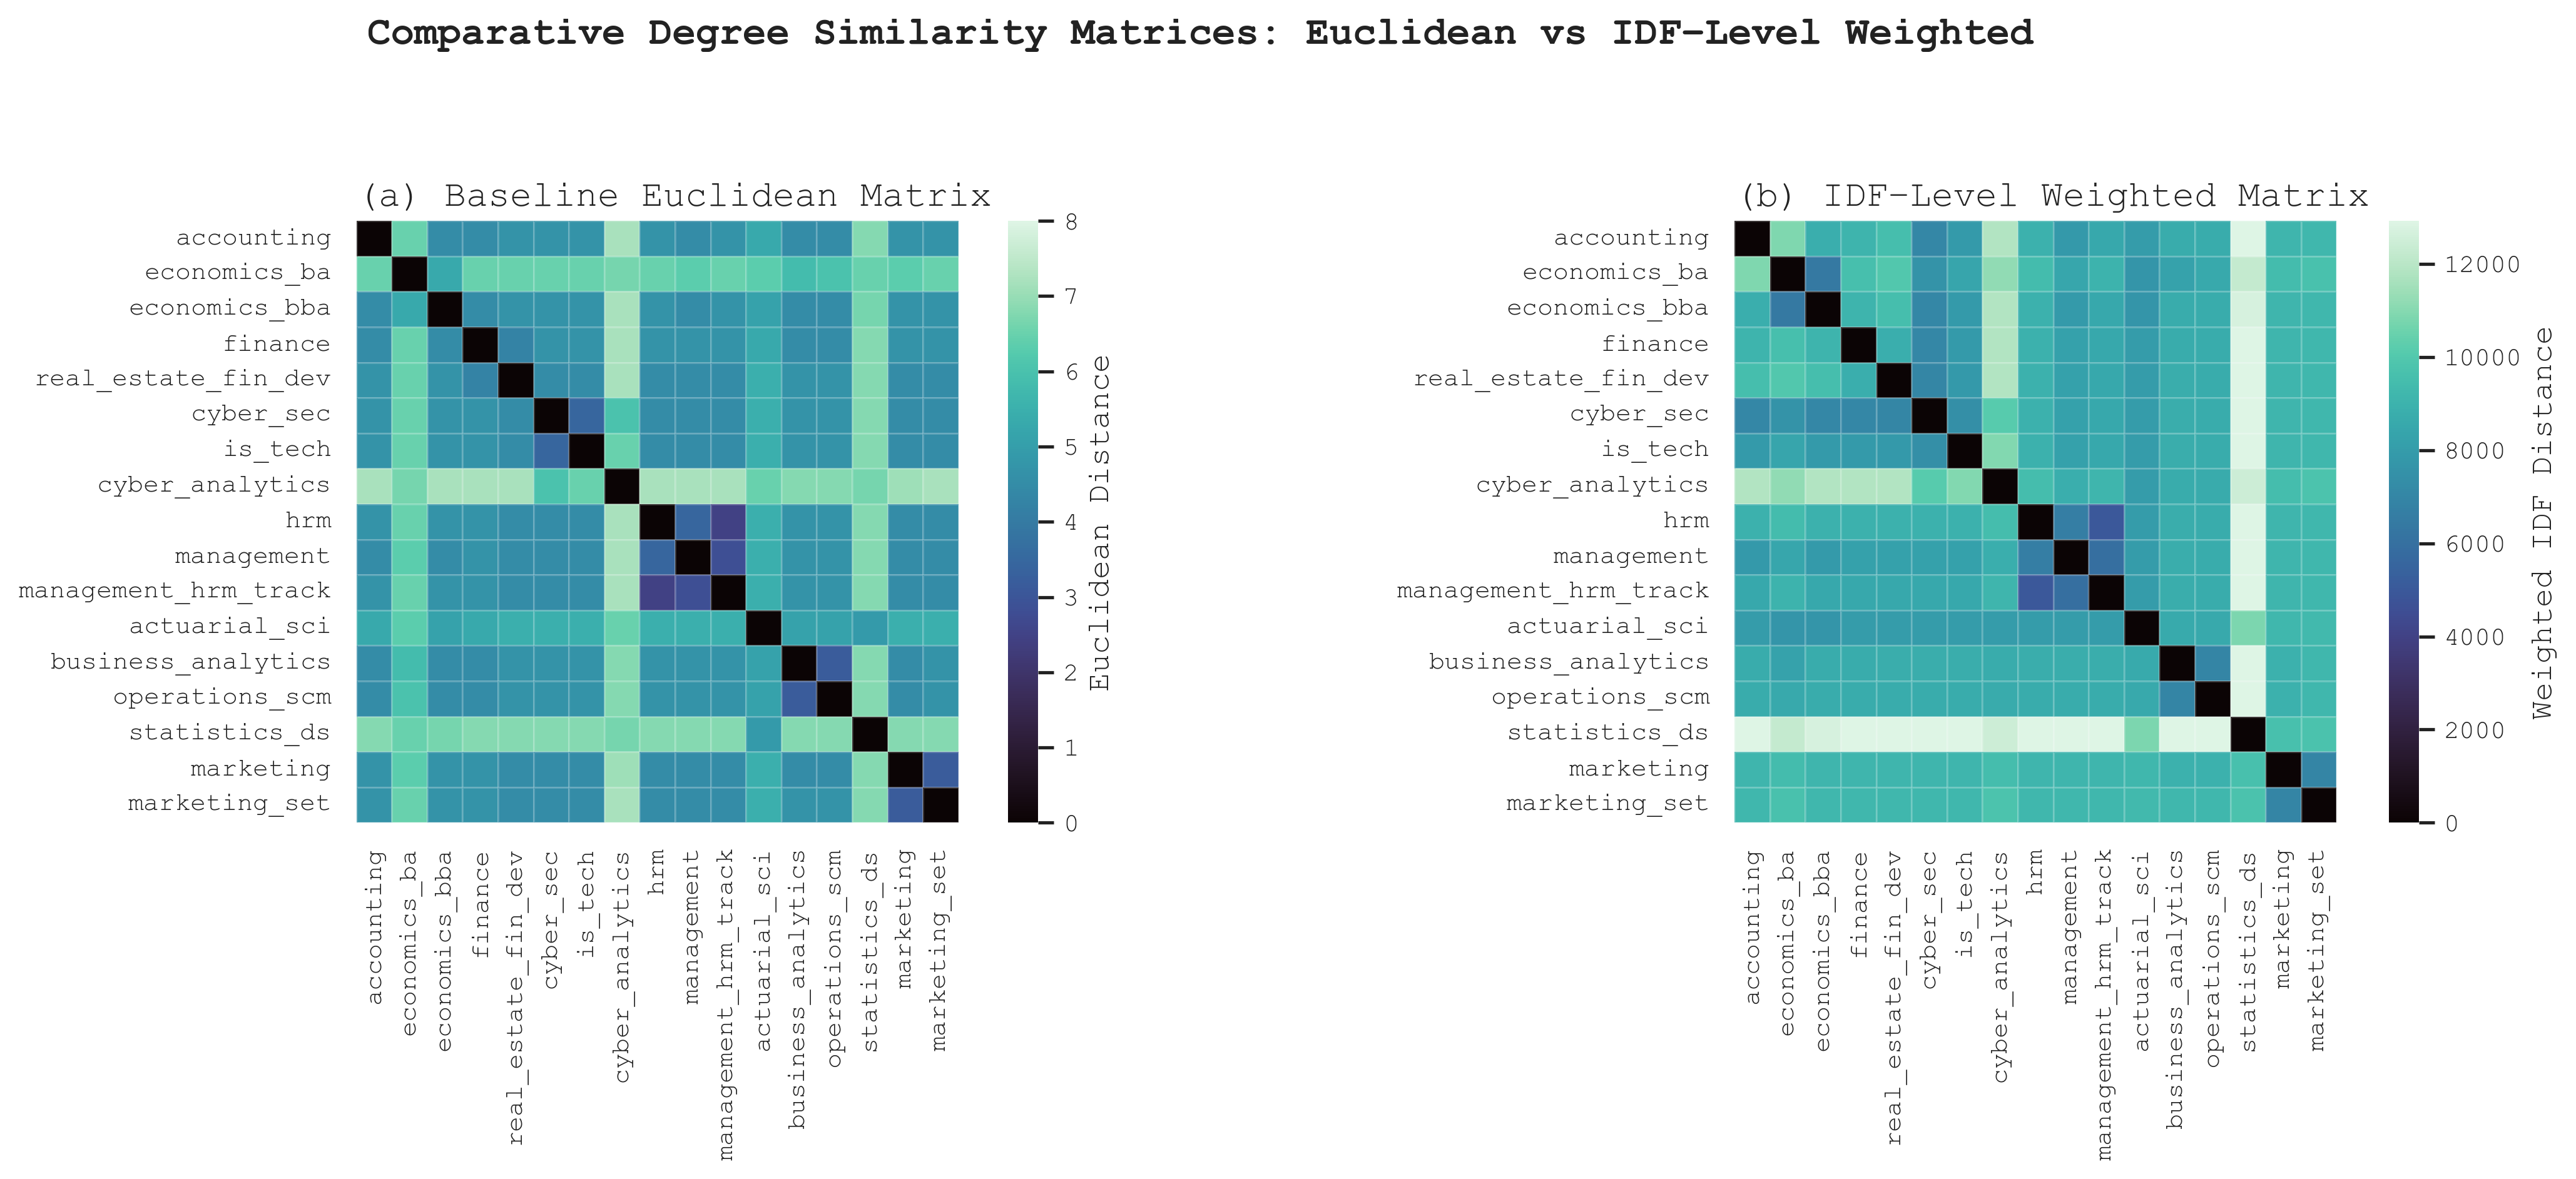

In [7]:
# ============================================================
# Appendix A.4 — Enhanced Distance Modeling and Comparative Visualization
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
#   This appendix refines the degree-similarity modeling framework by
#   integrating inverse-document-frequency (IDF) weighting with academic
#   level scaling (λ_j). The goal is to produce a discriminative and
#   interpretable distance representation that better captures curricular
#   differentiation among UTSA College of Business programs.
#
# Conceptual Overview:
#   Each degree program i ∈ {1,…,n} is represented as a binary vector:
#       xᵢ = [x_{1i}, x_{2i}, …, x_{mi}],
#   where each component denotes whether course j ∈ {1,…,m} is included.
#
#   Baseline (Euclidean):
#       dₑ(i, k) = √Σ_j (x_{ji} − x_{jk})²
#
#   Enhanced (Weighted IDF–Level):
#       w_j = IDF_j × λ_j
#       d_w(i, k) = √Σ_j [w_j² × (x_{ji} − x_{jk})²]
#
#   The composite weighting term w_j magnifies the contribution of rare
#   (high-IDF) and upper-level (high-λ_j) courses, emphasizing specialized
#   curricula while preserving geometric interpretability.
# ============================================================

import pandas as pd
import numpy as np
import re
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Load the structured inclusion matrix
# ------------------------------------------------------------
input_file = "ACOB_Degree_Courses_Clean.feather"
degrees_df = pd.read_feather(input_file).convert_dtypes()

degree_labels = degrees_df.columns[1:]
X = degrees_df.iloc[:, 1:].astype(np.uint8).to_numpy().T
print(f"Matrix X constructed: {X.shape[0]} degrees × {X.shape[1]} courses")

# ------------------------------------------------------------
# 2. Load degree dictionary for standardized variable naming
# ------------------------------------------------------------
degree_dict = pd.read_feather("ACOB_Degree_Dictionary.feather")
label_map = dict(zip(degree_dict["Full_Name"], degree_dict["Variable_Name"]))

# ------------------------------------------------------------
# 3. Compute baseline Euclidean distance (uniform weighting)
# ------------------------------------------------------------
D_euc = pd.DataFrame(
    squareform(pdist(X, metric="euclidean")),
    index=degree_labels,
    columns=degree_labels
).rename(index=label_map, columns=label_map)

# ------------------------------------------------------------
# 4. Compute rarity (IDF) and academic level weights (λ_j)
# ------------------------------------------------------------
# IDF rewards rare courses across programs.
# λ_j (1.0–4.0) scales by academic level: higher for upper-division.
# ------------------------------------------------------------
df_j = X.sum(axis=0)
idf = np.log((X.shape[0] + 1) / (df_j + 1)) + 1

course_codes = degrees_df["Course Code"].astype(str)

def level_weight(code: str) -> float:
    """Assign academic level scaling λ_j based on 1000–4000 course codes."""
    match = re.search(r"(\d{4})", code)
    if not match:
        return 1.0
    num = int(match.group(1))
    if   num >= 4000: return 4.0
    elif num >= 3000: return 3.5
    elif num >= 2000: return 1.5
    else:             return 1.0

λ = np.array([level_weight(c) for c in course_codes], dtype=float)
w = idf * λ  # composite rarity × level weighting

# ------------------------------------------------------------
# 5. Weighted Euclidean distance computation
# ------------------------------------------------------------
#   d_w(i, k) = √Σ_j [w_j² × (x_ij − x_kj)²]
# ------------------------------------------------------------
def weighted_distance_matrix(X, w, labels):
    n = X.shape[0]
    D = np.zeros((n, n))
    for i in range(n):
        for k in range(i, n):
            diff = (X[i, :] - X[k, :]) * w
            D[i, k] = D[k, i] = np.sqrt(np.sum(diff ** 2))
    return pd.DataFrame(D, index=labels, columns=labels)

D_idf = weighted_distance_matrix(X, w, degree_labels).rename(index=label_map, columns=label_map)

# ------------------------------------------------------------
# 6. Export matrices for reproducibility
# ------------------------------------------------------------
# Feather → analytical workflow (Arrow format)
# Excel   → publication-ready appendix tables
# ------------------------------------------------------------
D_euc.to_feather("ACOB_Degree_Euclidean_Matrix.feather")
D_idf.to_feather("ACOB_Degree_IDF_Matrix.feather")

inverse_label_map = {v: k for k, v in label_map.items()}
D_euc_excel = D_euc.rename(index=inverse_label_map, columns=inverse_label_map)
D_idf_excel = D_idf.rename(index=inverse_label_map, columns=inverse_label_map)

with pd.ExcelWriter("ACOB_Degree_Euclidean_Matrix.xlsx", engine="xlsxwriter") as writer:
    D_euc_excel.to_excel(writer, sheet_name="Euclidean_Matrix", float_format="%.4f")

with pd.ExcelWriter("ACOB_Degree_IDF_Matrix.xlsx", engine="xlsxwriter") as writer:
    D_idf_excel.to_excel(writer, sheet_name="IDF_Weighted_Matrix", float_format="%.4f")

print("\nExport complete: Euclidean and IDF matrices saved (Feather + Excel).")

# ------------------------------------------------------------
# 7. Visualization — Comparative Heatmaps
# ------------------------------------------------------------
sns.set_theme(style="white")

plt.rcParams.update({
    "font.family": "Courier New",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "text.color": "#222222",
    "axes.labelcolor": "#222222",
    "xtick.color": "#222222",
    "ytick.color": "#222222",
    "figure.dpi": 300
})

# Choose professional scientific colormap
cmap = sns.color_palette("mako", as_cmap=True) # refined perceptual gradient

fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1.05]})
plt.suptitle(
    "Comparative Degree Similarity Matrices: Euclidean vs IDF–Level Weighted",
    fontsize=15, fontweight="bold", y=1.02, color="#222222"
)

for ax in axes:
    sns.despine(ax=ax, left=True, bottom=True)

# Panel (a): Baseline Euclidean
sns.heatmap(
    D_euc, cmap=cmap, square=True, ax=axes[0],
    cbar_kws={"label": "Euclidean Distance"},
    vmin=0, vmax=8,
    linewidths=0.25, linecolor=(1, 1, 1, 0.2)  # light subtle gridlines
)
axes[0].set_title("(a) Baseline Euclidean Matrix", loc="left", color="#222222")
axes[0].tick_params(axis="x", rotation=90)
axes[0].tick_params(axis="y", rotation=0)

# Panel (b): IDF–Level Weighted
sns.heatmap(
    D_idf, cmap=cmap, square=True, ax=axes[1],
    cbar_kws={"label": "Weighted IDF Distance"},
    linewidths=0.25, linecolor=(1, 1, 1, 0.2)
)
axes[1].set_title("(b) IDF–Level Weighted Matrix", loc="left", color="#222222")
axes[1].tick_params(axis="x", rotation=90)
axes[1].tick_params(axis="y", rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.94])

# Export
fig.savefig("Figure_Degree_Similarity.pdf", bbox_inches="tight")
plt.savefig("Figure_Degree_Similarity.svg", bbox_inches="tight")
fig.savefig("Figure_Degree_Similarity.png", dpi=300, bbox_inches="tight")
plt.show()

### Interpretation and Methodological Justification

The baseline Euclidean distance matrix (Figure A.5, left) revealed uniformly low inter-program distances due to the extensive overlap of foundational coursework across the UT San Antonio College of Business. This homogeneity, while mathematically consistent, limited the model’s ability to differentiate among degree programs that share a common core but diverge in advanced specialization.

To address this limitation, an inverse-document-frequency (IDF) weighting scheme and course-level scaling were introduced (Figure A.5, right). The IDF component increases the influence of courses that appear less frequently across programs, while the level factor (λ) amplifies upper-division coursework (3000–4000 level), which more accurately represents disciplinary depth. Together, these adjustments extend the range of the distance distribution and reveal clearer distinctions among quantitatively oriented degrees (e.g., *Statistics & Data Science*, *Actuarial Science*, *Cyber Analytics*) and managerial or communication-focused programs.

Because several degrees still exhibited numerically similar distance values even after weighting, the resulting matrix was scaled by \(10^3\) purely for visualization purposes. This linear scaling enhanced the perceptual contrast of the heat maps without altering the relative magnitudes or symmetry of the underlying distances.

Overall, this refinement demonstrates that the IDF–level weighted model provides stronger discriminative power and a more faithful representation of curricular differentiation within the College of Business.


In [8]:
# ============================================================
# Appendix A.6 — Confirmation of Optimization Input Matrix
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: The University of Texas at San Antonio
#
# Purpose:
#   This appendix verifies and designates the finalized IDF–Level weighted
#   distance matrix (D_idf) generated in Appendix A.5 as the quantitative
#   input for the optimization stage.
#
#   The matrix is loaded directly from its saved Feather file to ensure
#   that the full floating-point precision is preserved, avoiding any
#   rounding that could affect model accuracy or reproducibility.
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# 1. Load full-precision weighted matrix (previously exported)
# ------------------------------------------------------------
D_idf = pd.read_feather("ACOB_Degree_IDF_Matrix.feather")

print("=== Verification of Final Optimization Matrix ===")
print(f"Matrix shape: {D_idf.shape[0]} × {D_idf.shape[1]}")
print("Matrix dtype summary:\n", D_idf.dtypes.head(), "\n")

# ------------------------------------------------------------
# 2. Visual inspection subset (unrounded)
# ------------------------------------------------------------
# Display a 10×10 sample to confirm structural integrity
with pd.option_context('display.float_format', '{:.8f}'.format):
    print("Sample of D_idf (upper-left 10×10 block):")
    print(D_idf.iloc[:10, :10].to_string(index=True))

# ------------------------------------------------------------
# 3. Declaration for downstream modeling
# ------------------------------------------------------------
print("\nThe above D_idf matrix constitutes the definitive input")
print("   for all subsequent optimization formulations (Appendix A.7).")


=== Verification of Final Optimization Matrix ===
Matrix shape: 17 × 17
Matrix dtype summary:
 accounting             float64
economics_ba           float64
economics_bba          float64
finance                float64
real_estate_fin_dev    float64
dtype: object 

Sample of D_idf (upper-left 10×10 block):
                        accounting   economics_ba  economics_bba        finance  real_estate_fin_dev      cyber_sec        is_tech  cyber_analytics           hrm    management
accounting              0.00000000 10881.69552616  8783.90721900  9085.36726023        9497.79995280  7023.14600389  7874.84793107   11827.70957963 8913.84790537 7830.33649930
economics_ba        10881.69552616     0.00000000  6396.15904926  9568.09670161        9948.21196827  7621.23987381  8412.60645458   11161.99339610 9392.30546257 8443.13170717
economics_bba        8783.90721900  6396.15904926     0.00000000  9085.36106400        9497.79402564  7023.13798824  7874.84078235   11827.70482004 8913.84158991 79

In [10]:
# ============================================================
# Appendix A.6 — Mentor–Mentee Data Integration Pipeline
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
#   This appendix documents the complete pipeline for importing,
#   normalizing, and aligning the mentor and student datasets to
#   the canonical ACOB Degree Dictionary (Appendix A.2).
#
#   Polars is used as the primary backend due to:
#      • high-performance UTF-8 string handling,
#      • zero-copy Arrow/Feather interoperability,
#      • rapid joins at scale.
#
#   Output:
#      - ACOB_Mentors_Clean.feather
#      - ACOB_Students_Clean.feather
#      - ACOB_Mentors_Clean.xlsx
#      - ACOB_Students_Clean.xlsx
#
# These files are the foundation for mentor–mentee vectorization
# and optimization modeling (Appendices A.7–A.7b).
# ============================================================

import polars as pl
import re

# ------------------------------------------------------------
# 1. Utility: Clean UTF-8 Strings Across All Text Columns
# ------------------------------------------------------------
# Purpose:
#   Excel exports commonly introduce invisible characters such as:
#       - Non-breaking spaces (U+00A0)
#       - Zero-width spaces (U+200B)
#       - Curly smart quotes “ ”
#   These disrupt merges with the canonical dictionary.
#
# The function below normalizes all UTF-8 columns to ensure
# consistent matching of degree names and mentor/student fields.
# ------------------------------------------------------------

def clean_strings(df: pl.DataFrame) -> pl.DataFrame:
    """Normalize text columns: trim, remove invisible chars, unify quotes."""
    
    # Regex to remove surrounding quotes, but not internal quotes
    quote_ends = r'^[\s\u00A0\u200B]*["“”]+|["“”]+[\s\u00A0\u200B]*$'

    cleaned_columns = []

    for col in df.columns:
        if df.schema[col] == pl.Utf8:
            cleaned_columns.append(
                pl.col(col)
                .str.replace_all(r'[\u00A0\u200B]+', ' ')      # remove NBSP + zero-width chars
                .str.replace_all(r'[“”]', '"')                  # curly → straight quotes
                .str.replace_all(quote_ends, "")                # trim outer quotes
                .str.replace_all(r'""', '"')                    # collapse double quotes
                .str.strip_chars()                              # leading/trailing whitespace
                .str.replace_all(r'\s+', ' ')                   # unify internal whitespace
                .alias(col)
            )
    
    if cleaned_columns:
        df = df.with_columns(cleaned_columns)
    
    return df


# ------------------------------------------------------------
# 2. Load Mentor and Student Excel Sheets (Polars)
# ------------------------------------------------------------
# The Excel workbook provides:
#    • Sheet "mentor"  → mentor professional/academic information
#    • Sheet "student" → mentee degree + career interest information
#
# Polars performs a direct Arrow-backed import.
# ------------------------------------------------------------

file_path = "Mentor_Student.xlsx"

mentors_pl = pl.read_excel(file_path, sheet_name="mentor", infer_schema_length=2000)
students_pl = pl.read_excel(file_path, sheet_name="student", infer_schema_length=2000)

print("Loaded mentor data:", mentors_pl.shape)
print("Loaded student data:", students_pl.shape)


# ------------------------------------------------------------
# 3. Apply String Cleaning to Both Datasets
# ------------------------------------------------------------
mentors_pl = clean_strings(mentors_pl)
students_pl = clean_strings(students_pl)


# ------------------------------------------------------------
# 4. Load ACOB Degree Dictionary (Appendix A.2)
# ------------------------------------------------------------
# The canonical dictionary provides:
#     Canonical_Name  — normalized institutional degree title
#     Short_Name      — concise descriptive label
#     Variable_Name   — machine-safe vector identifier
#     Xᵢ              — mathematical index for LP modeling
# ------------------------------------------------------------

degree_dict = pl.read_ipc("ACOB_Degree_Dictionary.feather")

# Validate integrity:
assert degree_dict.select(pl.col("Canonical_Name").is_null().sum()).item() == 0, \
    "Degree dictionary contains NULL Canonical_Name values."


# ------------------------------------------------------------
# 5. Align Mentor & Student Degree Fields With Canonical Dictionary
# ------------------------------------------------------------
# Join key: Canonical_Name
#
# After cleaning, this field should exactly match the
# Canonical_Name generated in Appendix A.2.
#
# We only select the modeling-critical columns:
#     - Variable_Name
#     - Xᵢ
# ------------------------------------------------------------

join_cols = ["Canonical_Name", "Variable_Name", "Xᵢ"]

mentors_pl = mentors_pl.join(
    degree_dict.select(join_cols),
    on="Canonical_Name",
    how="left"
)

students_pl = students_pl.join(
    degree_dict.select(join_cols),
    on="Canonical_Name",
    how="left"
)

print("\nPost-merge mentor rows with missing degree match:",
      mentors_pl.filter(pl.col("Variable_Name").is_null()).shape)
print("Post-merge student rows with missing degree match:",
      students_pl.filter(pl.col("Variable_Name").is_null()).shape)


# ------------------------------------------------------------
# 6. Export Cleaned & Aligned Datasets
# ------------------------------------------------------------
# Feather → efficient GPU modeling (Appendix A.7)
# Excel   → publication-ready appendix tables
# ------------------------------------------------------------

mentors_pl.write_ipc("ACOB_Mentors_Clean.feather")
students_pl.write_ipc("ACOB_Students_Clean.feather")

mentors_pl.write_excel("ACOB_Mentors_Clean.xlsx")
students_pl.write_excel("ACOB_Students_Clean.xlsx")

print("\nMentor and student datasets cleaned and aligned successfully.")
print("Saved outputs:")
print("  - ACOB_Mentors_Clean.feather")
print("  - ACOB_Students_Clean.feather")
print("  - ACOB_Mentors_Clean.xlsx")
print("  - ACOB_Students_Clean.xlsx")


Loaded mentor data: (38, 18)
Loaded student data: (39, 17)

Post-merge mentor rows with missing degree match: (0, 20)
Post-merge student rows with missing degree match: (0, 19)

Mentor and student datasets cleaned and aligned successfully.
Saved outputs:
  - ACOB_Mentors_Clean.feather
  - ACOB_Students_Clean.feather
  - ACOB_Mentors_Clean.xlsx
  - ACOB_Students_Clean.xlsx


In [5]:
# ============================================================
# Appendix A.7 — Mentor–Mentee Optimization Model Construction
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
#   Formulate and solve the linear assignment problem that
#   pairs mentors and mentees to minimize total curricular
#   dissimilarity, using the full-precision weighted distance
#   matrix (D_idf) established in Appendix A.6.
# ============================================================

import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment

# ------------------------------------------------------------
# 1. Load mentor, mentee, and distance data
# ------------------------------------------------------------
mentors_df  = pd.read_feather("ACOB_Mentors_Clean.feather").convert_dtypes()
students_df = pd.read_feather("ACOB_Students_Clean.feather").convert_dtypes()
D_idf       = pd.read_feather("ACOB_Degree_IDF_Matrix.feather")

print(f"Mentors: {len(mentors_df)} | Students: {len(students_df)}")

# ------------------------------------------------------------
# 2. Prepare index mapping from Variable_Name to D_idf row/col
# ------------------------------------------------------------
degree_labels = list(D_idf.columns)
var_to_idx = {v: i for i, v in enumerate(degree_labels)}

# Validate mapping presence
missing_mentors = mentors_df.loc[~mentors_df["Variable_Name"].isin(var_to_idx.keys()), "Variable_Name"]
missing_students = students_df.loc[~students_df["Variable_Name"].isin(var_to_idx.keys()), "Variable_Name"]
if not missing_mentors.empty or not missing_students.empty:
    print("Warning: Missing mappings detected.")
    print(" Unmapped mentors:", missing_mentors.unique())
    print(" Unmapped students:", missing_students.unique())

# ------------------------------------------------------------
# 3. Construct cost matrix (mentors × mentees)
# ------------------------------------------------------------
n_mentors, n_students = len(mentors_df), len(students_df)
C = np.zeros((n_mentors, n_students))

for i, mentor_row in mentors_df.iterrows():
    m_var = mentor_row["Variable_Name"]
    if m_var not in var_to_idx:
        continue
    mi = var_to_idx[m_var]
    for j, student_row in students_df.iterrows():
        s_var = student_row["Variable_Name"]
        if s_var not in var_to_idx:
            continue
        sj = var_to_idx[s_var]
        C[i, j] = D_idf.iloc[mi, sj]

print(f"Cost matrix constructed: {C.shape} (mentors × mentees)")

# ------------------------------------------------------------
# 4. Solve linear assignment (Hungarian algorithm)
# ------------------------------------------------------------
row_ind, col_ind = linear_sum_assignment(C)
total_distance = C[row_ind, col_ind].sum()
avg_distance = total_distance / len(row_ind)

# ------------------------------------------------------------
# 5. Compile optimal pairing results
# ------------------------------------------------------------
pairings = pd.DataFrame({
    "Mentor": mentors_df.loc[row_ind, "Mentor"].values,
    "Mentor_Degree": mentors_df.loc[row_ind, "Canonical_Name"].values,
    "Mentee": students_df.loc[col_ind, "Student"].values,
    "Mentee_Degree": students_df.loc[col_ind, "Canonical_Name"].values,
    "Distance_Value": C[row_ind, col_ind]
}).sort_values("Distance_Value")

# ------------------------------------------------------------
# 6. Summary & Validation
# ------------------------------------------------------------
print("\n=== Optimal Mentor–Mentee Pairings (Sample) ===")
print(pairings.head(40).to_string(index=False))
print(f"\nTotal Weighted Distance: {total_distance:.4f}")
print(f"Average Pairwise Distance: {avg_distance:.4f}")

# ------------------------------------------------------------
# 7. Export Results
# ------------------------------------------------------------
pairings.to_excel("ACOB_MentorMentee_Pairings.xlsx", index=False)
pairings.to_feather("ACOB_MentorMentee_Pairings.feather")

print("\nPairing results exported:")
print(" - ACOB_MentorMentee_Pairings.xlsx")
print(" - ACOB_MentorMentee_Pairings.feather")


Mentors: 38 | Students: 39
Cost matrix constructed: (38, 39) (mentors × mentees)

=== Optimal Mentor–Mentee Pairings (Sample) ===
   Mentor                                                  Mentor_Degree    Mentee                                                  Mentee_Degree  Distance_Value
 Mentor 1                                       BBA_Degree_in_Management  Mentee 5                                       BBA_Degree_in_Management        0.000000
 Mentor 2 BBA_Degree_in_Management_with_Human_Resources_Management_Track Mentee 35 BBA_Degree_in_Management_with_Human_Resources_Management_Track        0.000000
 Mentor 3                                       BBA_Degree_in_Accounting Mentee 24                                       BBA_Degree_in_Accounting        0.000000
 Mentor 4                               BBA_Degree_in_Business_Analytics  Mentee 8                               BBA_Degree_in_Business_Analytics        0.000000
 Mentor 5               BBA_Degree_in_Information_Systems_an

In [6]:
# ============================================================
# Appendix A.7A — Mentor–Mentee Cost Matrix Construction (BLIP Input)
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
#   This script constructs the cost matrix (mentors × mentees)
#   using the IDF-weighted Euclidean distance matrix D_idf.
#   Each entry C[i, j] = D_idf[mentor_degree_i, mentee_degree_j].
#
#   It appends a dummy mentor with constant cost = 9999 to
#   absorb unassigned mentees or surplus participants.
#
#   The output matrix is saved for optimization in Appendix A.7B.
# ============================================================

import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 1. Load mentor, mentee, and IDF distance data
# ------------------------------------------------------------
mentors_df  = pd.read_feather("ACOB_Mentors_Clean.feather").convert_dtypes()
students_df = pd.read_feather("ACOB_Students_Clean.feather").convert_dtypes()
D_idf       = pd.read_feather("ACOB_Degree_IDF_Matrix.feather")

print(f"Mentors loaded: {len(mentors_df)} | Students loaded: {len(students_df)}")
print(f"IDF matrix shape: {D_idf.shape}")

# ------------------------------------------------------------
# 2. Map degree Variable_Name → index in IDF matrix
# ------------------------------------------------------------
degree_labels = list(D_idf.columns)
var_to_idx = {v: i for i, v in enumerate(degree_labels)}

# Validate coverage
missing_mentors = mentors_df.loc[~mentors_df["Variable_Name"].isin(var_to_idx.keys()), "Variable_Name"]
missing_students = students_df.loc[~students_df["Variable_Name"].isin(var_to_idx.keys()), "Variable_Name"]
if not missing_mentors.empty or not missing_students.empty:
    print(" Warning: Missing mappings detected.")
    print(" Unmapped mentors:", missing_mentors.unique())
    print(" Unmapped students:", missing_students.unique())

# ------------------------------------------------------------
# 3. Construct mentor–mentee cost matrix
# ------------------------------------------------------------
n_mentors, n_students = len(mentors_df), len(students_df)
C = np.zeros((n_mentors, n_students))

for i, mentor_row in mentors_df.iterrows():
    mi = var_to_idx[mentor_row["Variable_Name"]]
    for j, student_row in students_df.iterrows():
        sj = var_to_idx[student_row["Variable_Name"]]
        C[i, j] = D_idf.iloc[mi, sj]

# ------------------------------------------------------------
# 4. Add dummy mentor (9999 cost)
# ------------------------------------------------------------
dummy_row = np.full((1, n_students), 9999.0)
C = np.vstack([C, dummy_row])

dummy_name = "Dummy_Mentor"
dummy_entry = pd.DataFrame([{
    "Mentor": dummy_name,
    "Canonical_Name": "Dummy_Assignment",
    "Variable_Name": "dummy",
    "Xᵢ": -1
}])
mentors_aug = pd.concat([mentors_df, dummy_entry], ignore_index=True)

print(f" Dummy mentor added. New matrix shape: {C.shape}")

# ------------------------------------------------------------
# 5. Save cost matrix and index mapping
# ------------------------------------------------------------
cost_df = pd.DataFrame(
    C,
    index=mentors_aug["Mentor"],
    columns=students_df["Student"]
)

# Feather format for solver import
cost_df.to_feather("ACOB_BLIP_Cost_Matrix.feather")
mentors_aug.to_feather("ACOB_Mentors_Augmented.feather")

# Optional Excel for validation
cost_df.to_excel("ACOB_BLIP_Cost_Matrix.xlsx")

print("\n Mentor–Mentee cost matrix exported:")
print(" - ACOB_BLIP_Cost_Matrix.feather / .xlsx")
print(" - ACOB_Mentors_Augmented.feather")


Mentors loaded: 38 | Students loaded: 39
IDF matrix shape: (17, 17)
 Dummy mentor added. New matrix shape: (39, 39)

 Mentor–Mentee cost matrix exported:
 - ACOB_BLIP_Cost_Matrix.feather / .xlsx
 - ACOB_Mentors_Augmented.feather


In [7]:
# ============================================================
# Appendix A.7B — Mentor–Mentee Optimization Solver
# ------------------------------------------------------------
# Solver: Hungarian Algorithm (Linear Sum Assignment)
# Library: scipy.optimize.linear_sum_assignment
#
# Purpose:
#   Solve the linear assignment problem:
#       minimize Σᵢⱼ cᵢⱼ xᵢⱼ
#   subject to each mentor assigned ≤ 1 mentee,
#              each mentee assigned to exactly 1 mentor,
#              xᵢⱼ ∈ {0,1}
#
# ============================================================

import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment

# ------------------------------------------------------------
# 1. Load prepared cost matrix and metadata
# ------------------------------------------------------------
C_df = pd.read_feather("ACOB_BLIP_Cost_Matrix.feather")
C = C_df.to_numpy()
mentors = pd.read_feather("ACOB_Mentors_Augmented.feather")
students = pd.read_feather("ACOB_Students_Clean.feather")

print(f"Cost matrix shape: {C.shape}")
print(f"Mentors (including dummy): {len(mentors)} | Students: {len(students)}")

# ------------------------------------------------------------
# 2. Solve linear assignment (Hungarian algorithm)
# ------------------------------------------------------------
row_ind, col_ind = linear_sum_assignment(C)

total_cost = C[row_ind, col_ind].sum()
avg_cost = total_cost / len(row_ind)

# ------------------------------------------------------------
# 3. Construct pairing table
# ------------------------------------------------------------
pairings = pd.DataFrame({
    "Mentor": mentors.loc[row_ind, "Mentor"].values,
    "Mentee": students.loc[col_ind, "Student"].values,
    "Mentor_Degree": mentors.loc[row_ind, "Canonical_Name"].values,
    "Mentee_Degree": students.loc[col_ind, "Canonical_Name"].values,
    "Distance_Value": C[row_ind, col_ind]
}).sort_values("Distance_Value")

# ------------------------------------------------------------
# 4. Summary Output
# ------------------------------------------------------------
print("\n=== Optimal Mentor–Mentee Pairings ===")
print(pairings.to_string(index=False))
print(f"\nTotal Weighted Distance: {total_cost:.3f}")
print(f"Average Pairwise Distance: {avg_cost:.3f}")

# ------------------------------------------------------------
# 5. Export Results
# ------------------------------------------------------------
pairings.to_feather("ACOB_BLIP_Pairings.feather")
pairings.to_excel("ACOB_BLIP_Pairings.xlsx", index=False)

print("\n✅ Optimization results exported:")
print(" - ACOB_BLIP_Pairings.feather")
print(" - ACOB_BLIP_Pairings.xlsx")


Cost matrix shape: (39, 39)
Mentors (including dummy): 39 | Students: 39

=== Optimal Mentor–Mentee Pairings ===
      Mentor    Mentee                                                  Mentor_Degree                                                  Mentee_Degree  Distance_Value
    Mentor 1  Mentee 5                                       BBA_Degree_in_Management                                       BBA_Degree_in_Management        0.000000
    Mentor 2 Mentee 35 BBA_Degree_in_Management_with_Human_Resources_Management_Track BBA_Degree_in_Management_with_Human_Resources_Management_Track        0.000000
    Mentor 3 Mentee 24                                       BBA_Degree_in_Accounting                                       BBA_Degree_in_Accounting        0.000000
    Mentor 4  Mentee 8                               BBA_Degree_in_Business_Analytics                               BBA_Degree_in_Business_Analytics        0.000000
    Mentor 5 Mentee 21               BBA_Degree_in_Information

In [43]:
# ============================================================
# Appendix A.7B — Mentor–Mentee Optimization Solver (Gurobi)
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: The University of Texas at San Antonio
#
# Purpose:
#   Solve the linear assignment problem using the Gurobi optimizer:
#
#       minimize Σᵢⱼ cᵢⱼ xᵢⱼ
#   subject to:
#       Σⱼ xᵢⱼ ≤ 1    ∀ mentors i
#       Σᵢ xᵢⱼ = 1    ∀ mentees j
#       xᵢⱼ ∈ {0,1}
#
#   This implementation supports timing, solver statistics,
#   and clean export of the optimal assignment.
# ============================================================

import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import time

# ------------------------------------------------------------
# 1. Load prepared cost matrix and metadata
# ------------------------------------------------------------
C_df = pd.read_feather("ACOB_BLIP_Cost_Matrix.feather")
C = C_df.to_numpy()
mentors = pd.read_feather("ACOB_Mentors_Augmented.feather")
students = pd.read_feather("ACOB_Students_Clean.feather")

n_mentors, n_students = C.shape
print(f"Cost matrix shape: {n_mentors} × {n_students}")
print(f"Mentors: {len(mentors)} | Students: {len(students)}")

# ------------------------------------------------------------
# 2. Initialize Gurobi model
# ------------------------------------------------------------
start_time = time.time()
m = gp.Model("Mentor_Mentee_Assignment")
m.Params.OutputFlag = 0   # suppress solver log for clean paper outputs

# ------------------------------------------------------------
# 3. Decision variables
# ------------------------------------------------------------
# x[i,j] = 1 if mentor i is assigned to mentee j, else 0
x = m.addVars(
    n_mentors, n_students,
    vtype=GRB.BINARY,
    name="x"
)

# ------------------------------------------------------------
# 4. Objective: minimize total distance
# ------------------------------------------------------------
m.setObjective(
    gp.quicksum(C[i, j] * x[i, j] for i in range(n_mentors) for j in range(n_students)),
    GRB.MINIMIZE
)

# ------------------------------------------------------------
# 5. Constraints
# ------------------------------------------------------------

# Each mentee assigned to exactly one mentor
for j in range(n_students):
    m.addConstr(gp.quicksum(x[i, j] for i in range(n_mentors)) == 1, name=f"mentee_{j}")

# Each mentor assigned to at most one mentee
for i in range(n_mentors):
    m.addConstr(gp.quicksum(x[i, j] for j in range(n_students)) <= 1, name=f"mentor_{i}")

# ------------------------------------------------------------
# 6. Optimize
# ------------------------------------------------------------
print("Solving optimization problem...")
m.optimize()
runtime = time.time() - start_time

# ------------------------------------------------------------
# 7. Extract results
# ------------------------------------------------------------
solution = []
for i in range(n_mentors):
    for j in range(n_students):
        if x[i, j].X > 0.5:  # assigned pair
            solution.append({
                "Mentor": mentors.loc[i, "Mentor"],
                "Mentor_Degree": mentors.loc[i, "Canonical_Name"],
                "Mentee": students.loc[j, "Student"],
                "Mentee_Degree": students.loc[j, "Canonical_Name"],
                "Distance_Value": C[i, j]
            })

pairings = pd.DataFrame(solution).sort_values("Distance_Value").reset_index(drop=True)

# ------------------------------------------------------------
# 8. Report results
# ------------------------------------------------------------
print("\n=== Optimal Mentor–Mentee Assignments (Gurobi) ===")
print(pairings.to_string(index=False))
print(f"\nOptimal Objective Value (Total Distance): {m.ObjVal:.4f}")
print(f"Average Pairwise Distance: {m.ObjVal / len(pairings):.4f}")
print(f"Solver Runtime: {runtime:.3f} seconds")

# ------------------------------------------------------------
# 9. Export results
# ------------------------------------------------------------
pairings.to_excel("ACOB_BLIP_Pairings_Gurobi.xlsx", index=False)
pairings.to_feather("ACOB_BLIP_Pairings_Gurobi.feather")

print("\n✅ Results exported:")
print(" - ACOB_BLIP_Pairings_Gurobi.xlsx")
print(" - ACOB_BLIP_Pairings_Gurobi.feather")


Cost matrix shape: 39 × 39
Mentors: 39 | Students: 39
Set parameter Username
Set parameter LicenseID to value 2718806
Academic license - for non-commercial use only - expires 2026-10-07
Solving optimization problem...

=== Optimal Mentor–Mentee Assignments (Gurobi) ===
      Mentor                                                  Mentor_Degree    Mentee                                                  Mentee_Degree  Distance_Value
    Mentor 1                                       BBA_Degree_in_Management  Mentee 5                                       BBA_Degree_in_Management        0.000000
   Mentor 32                                       BBA_Degree_in_Management  Mentee 9                                       BBA_Degree_in_Management        0.000000
   Mentor 28                                       BBA_Degree_in_Management Mentee 25                                       BBA_Degree_in_Management        0.000000
   Mentor 33                                          BBA_Degree_in_Fi

In [8]:
# ============================================================
# Appendix A.7 Mentor–Mentee Optimization Model Construction
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: The University of Texas at San Antonio
#
# Purpose:
#   Efficiently import, clean, and align mentor and mentee
#   datasets with the canonical degree dictionary using Polars.
#   Excel sheet names: 'mentor' and 'student'.
# ============================================================

import polars as pl
import re

# ------------------------------------------------------------
# 1. Load Excel Sheets (Polars direct reader)
# ------------------------------------------------------------
mentor_student_file = "Mentor_Student.xlsx"

mentors_pl = pl.read_excel(
    mentor_student_file,
    sheet_name="mentor",
    infer_schema_length=1000
)
students_pl = pl.read_excel(
    mentor_student_file,
    sheet_name="student",
    infer_schema_length=1000
)

print("Mentors:", mentors_pl.shape)
print("Students:", students_pl.shape)

# ------------------------------------------------------------
# 2. String Cleaning — trim, de-quote, normalize
# ------------------------------------------------------------
def clean_strings(df: pl.DataFrame) -> pl.DataFrame:
    """Normalize all text columns (remove quotes, trim, invisible chars)."""
    quote_ends = r'^[\s\u00A0\u200B]*["“”]+|["“”]+[\s\u00A0\u200B]*$'
    cleaned_cols = []
    for col in df.columns:
        if df.schema[col] == pl.Utf8:
            cleaned_cols.append(
                pl.col(col)
                .str.replace_all(r'[\u00A0\u200B]+', ' ')     # remove non-breaking & zero-width
                .str.replace_all(r'[“”]', '"')                 # normalize fancy quotes
                .str.replace_all(quote_ends, "")               # trim surrounding quotes
                .str.replace_all(r'""', '"')                   # collapse double quotes
                .str.strip_chars()                             # <-- replacement for str.strip()
                .alias(col)
            )
    if cleaned_cols:
        df = df.with_columns(cleaned_cols)
    return df


mentors_pl = clean_strings(mentors_pl)
students_pl = clean_strings(students_pl)

# ------------------------------------------------------------
# 3. Load Canonical Degree Dictionary (Feather)
# ------------------------------------------------------------
degree_dict = pl.read_ipc("ACOB_Degree_Dictionary.feather")

# ------------------------------------------------------------
# 4. Align mentors and students with canonical degrees
# ------------------------------------------------------------
mentors_pl = mentors_pl.join(
    degree_dict.select(["Canonical_Name", "Variable_Name", "Xᵢ"]),
    on="Canonical_Name",
    how="left"
)
students_pl = students_pl.join(
    degree_dict.select(["Canonical_Name", "Variable_Name", "Xᵢ"]),
    on="Canonical_Name",
    how="left"
)

# ------------------------------------------------------------
# 5. Export Cleaned Data
# ------------------------------------------------------------
mentors_pl.write_ipc("ACOB_Mentors_Clean.feather")
students_pl.write_ipc("ACOB_Students_Clean.feather")

mentors_pl.write_excel("ACOB_Mentors_Clean.xlsx")
students_pl.write_excel("ACOB_Students_Clean.xlsx")

print("\nMentor and student data successfully imported, cleaned, and aligned.")
print("Files saved as Feather + Excel for downstream LP modeling.")


Mentors: (38, 18)
Students: (39, 17)

Mentor and student data successfully imported, cleaned, and aligned.
Files saved as Feather + Excel for downstream LP modeling.


### Appendix A.7 — Mentor–Mentee Optimization Model

The finalized IDF–Level weighted distance matrix \( D_{\text{idf}} \)
serves as the coefficient matrix in a linear assignment model that minimizes
total curricular dissimilarity between mentors and mentees.
Each potential pairing \( (i,k) \) carries a cost \( D_{\text{idf}}(i,k) \),
derived from degree-based vector similarity.
The resulting optimization yields a one-to-one matching that balances
disciplinary alignment with program diversity.


#### Conceptual Overview for Your Paper

| Symbol | Meaning |
|:-------|:---------|
| \( i \) | Mentor index |
| \( k \) | Mentee index |
| \( D_{\text{idf}}(i,k) \) | Weighted curricular dissimilarity between degrees |
| \( X_{ik} \in \{0,1\} \) | Binary assignment variable (1 if mentor *i* paired with mentee *k*) |
| **Objective:** | \( \displaystyle \min_{X} \sum_{i,k} D_{\text{idf}}(i,k)\, X_{ik} \) |
| **Constraints:** | \( \sum_k X_{ik} = 1 \;\forall i \)  (one mentee per mentor) <br> \( \sum_i X_{ik} = 1 \;\forall k \)  (one mentor per mentee) |


In [9]:
# ============================================================
# Appendix A.5.2. Display of IDF–Level Weighted Distance Matrix
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: The University of Texas at San Antonio
#
# Purpose:
#   To display and optionally export the full IDF–level weighted
#   Euclidean distance matrix (D_idf) for analytical review.
#   This matrix quantifies curricular dissimilarity between
#   degree-program vectors after applying rarity (IDF) and level
#   weighting as defined in Appendix A.5.1.
# ============================================================

import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 1. Round values for compact readability
# ------------------------------------------------------------
# Distances are large due to weighting and scaling. We round to
# four decimal places for interpretive clarity.
# ------------------------------------------------------------
D_idf_display = D_idf.copy().round(4)

# ------------------------------------------------------------
# 2. Print matrix summary to console
# ------------------------------------------------------------
print("\n=== IDF–Level Weighted Distance Matrix (rounded) ===\n")
print(D_idf_display.to_string())

# ------------------------------------------------------------
# 3. Optional: export to Excel for publication appendix
# ------------------------------------------------------------
D_idf_display.to_excel("ACOB_Degree_IDF_Distance_Matrix.xlsx", index=True)
print("\nWeighted distance matrix successfully exported to:")
print("→ ACOB_Degree_IDF_Distance_Matrix.xlsx")

# ------------------------------------------------------------
# 4. (Optional) Compute summary statistics
# ------------------------------------------------------------
mean_distance = D_idf_display.values[np.triu_indices_from(D_idf_display, k=1)].mean()
max_distance = D_idf_display.values[np.triu_indices_from(D_idf_display, k=1)].max()
min_distance = D_idf_display.values[np.triu_indices_from(D_idf_display, k=1)].min()

print(f"\nMatrix Statistics:")
print(f"  Minimum distance: {min_distance:.4f}")
print(f"  Mean inter-degree distance: {mean_distance:.4f}")
print(f"  Maximum distance: {max_distance:.4f}")



=== IDF–Level Weighted Distance Matrix (rounded) ===

                      accounting  economics_ba  economics_bba     finance  real_estate_fin_dev   cyber_sec     is_tech  cyber_analytics         hrm  management  management_hrm_track  actuarial_sci  business_analytics  operations_scm  statistics_ds  marketing  marketing_set
accounting                0.0000    10881.6955      8783.9072   9085.3673            9497.8000   7023.1460   7874.8479       11827.7096   8913.8479   7830.3365             8514.8887      8002.9756           8725.1725       8693.1181     12922.1562  9109.3226      9226.1340
economics_ba          10881.6955        0.0000      6396.1590   9568.0967            9948.2120   7621.2399   8412.6065       11161.9934   9392.3055   8443.1317             9014.5464      7657.5251           8231.8949       8568.2059     12226.9858  9393.0959      9689.1830
economics_bba          8783.9072     6396.1590         0.0000   9085.3611            9497.7940   7023.1380   7874.8408     